Estimate the amount of misrepresentation on the sparse data 

17-04-2025

In [22]:
import tensorflow as tf
import keras

print(tf.__version__)
keras.backend.clear_session()
print(tf.config.list_physical_devices("GPU"))

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
import numpy as np
import pandas as pd

In [24]:
from pathlib import Path

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
from tensorflow.keras.models import load_model

model_path = "/home/t.afanasyeva/deep_learning_anaemias/output/250208_cytpix/250208_EfficientNetB0_v2.keras"
model = load_model(model_path)

In [28]:
path_in = Path.cwd().parent / "resources/cytpix/"

In [29]:
import shutil
from tqdm import tqdm

class_names = [
    "discocyte",
    "holly_leaf",
    "granular",
    "sickle",
    "echinocyte",
]

all_discocytes_path = path_in / "combined/discocyte"
training_discocytes_path = path_in / "augmented/discocyte"
all_but_trainign_discocytes_path = path_in / "not_training_discocyte/discocyte"

for class_name in class_names:
    class_dir = path_in / "not_training_discocyte" / class_name
    class_dir.mkdir(parents=True, exist_ok=True)

In [9]:
# file_count_all = len(list(all_discocytes_path.iterdir()))
# print(f"Number of files in {all_discocytes_path}: {file_count_all}")

# training_files = {
#     file.name for file in training_discocytes_path.iterdir() if file.is_file()
# }
# for file in tqdm(all_discocytes_path.iterdir(), desc="Processing files"):
#     if file.is_file() and file.name not in training_files:
#         destination = all_but_trainign_discocytes_path / file.name
#         shutil.copy(file, destination)


# file_count_not_training = len(list(all_but_trainign_discocytes_path.iterdir()))
# print(
#     f"Number of files in {all_but_trainign_discocytes_path}: {file_count_not_training}"
# )

In [30]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 224

test_ds = keras.utils.image_dataset_from_directory(
    all_but_trainign_discocytes_path.parent,
    label_mode="categorical",
    class_names=[
        "discocyte",
        "holly_leaf",
        "granular",
        "sickle",
        "echinocyte",
    ],
    color_mode="rgb",
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=93,
    data_format="channels_last",
    verbose=True,
)
class_names = test_ds.class_names
image_paths = [f for f in test_ds.file_paths]
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

Found 92593 files belonging to 5 classes.


In [31]:
y_test = tf.concat([y for _, y in test_ds], axis=0)
y_test = np.argmax(y_test, axis=1)
y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)

2025-04-15 10:18:11.117520: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2894/2894 ━━━━━━━━━━━━━━━━━━━━ 107s 35ms/step


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(
    y_test, y_pred, target_names=class_names, zero_division=np.nan
)
print(report)

              precision    recall  f1-score   support

   discocyte       1.00      0.95      0.97     92593
  holly_leaf       0.00       nan      0.00         0
    granular       0.00       nan      0.00         0
      sickle       0.00       nan      0.00         0
  echinocyte       0.00       nan      0.00         0

    accuracy                           0.95     92593
   macro avg       0.20      0.95      0.19     92593
weighted avg       1.00      0.95      0.97     92593



In [34]:
class_names = [
    "discocyte",
    "holly_leaf",
    "granular",
    "sickle",
    "echinocyte",
]

for class_index, class_name in enumerate(class_names):
    count = np.count_nonzero(y_pred == class_index)
    print(f"Class '{class_name}': {count} predictions")

Class 'discocyte': 87711 predictions
Class 'holly_leaf': 58 predictions
Class 'granular': 1687 predictions
Class 'sickle': 1 predictions
Class 'echinocyte': 3136 predictions


In [ ]:
# import csv

# report_path = "/home/t.afanasyeva/deep_learning_anaemias/output/250208_cytpix/classification_report.csv"

# # Split the report into lines
# report_lines = report.split("\n")

# # Extract the header and data lines
# header = report_lines[0].split()
# data_lines = [line.split() for line in report_lines[2:-3]]

# # Write to CSV
# with open(report_path, mode="w", newline="") as file:
#     writer = csv.writer(file)
#     writer.writerow(header)
#     writer.writerows(data_lines)

# print(f"Classification report exported to {report_path}")

Classification report exported to /home/t.afanasyeva/deep_learning_anaemias/output/250208_cytpix/classification_report.csv


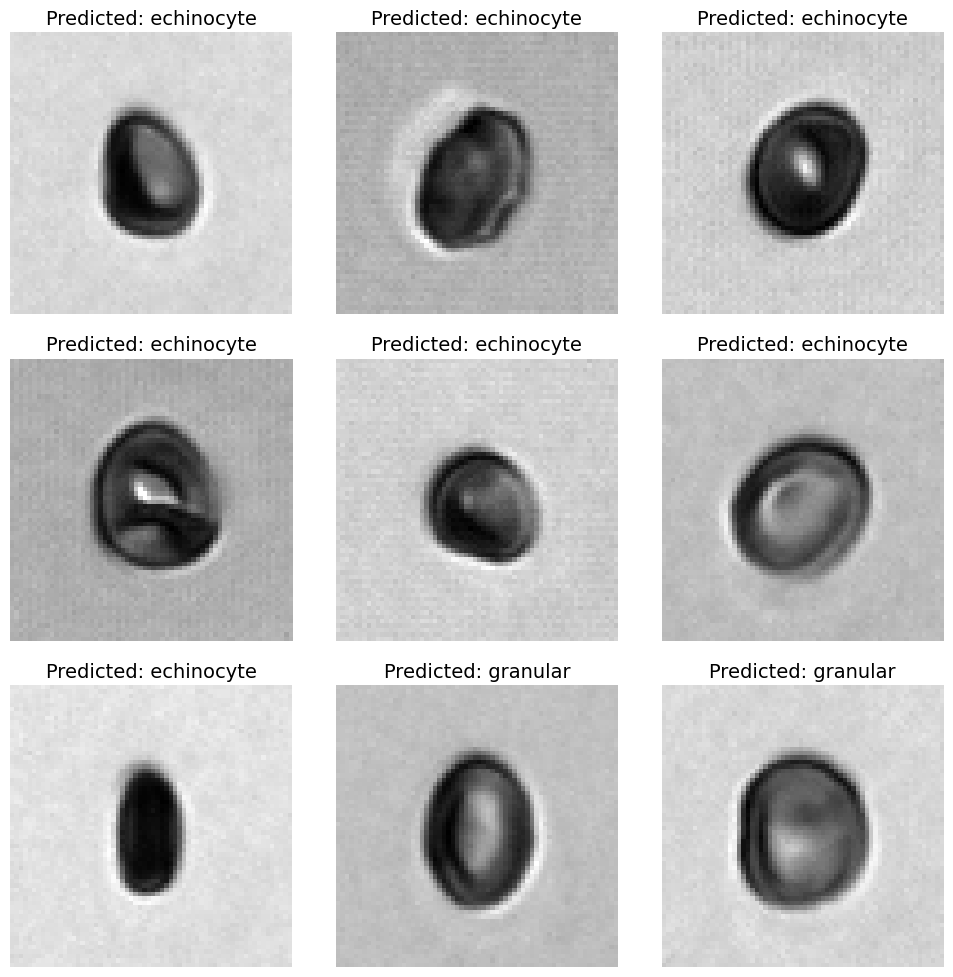

In [36]:
from tensorflow.keras.utils import array_to_img
import matplotlib.pyplot as plt


def print_image(image_paths, class_names):
    plt.figure(figsize=(10, 10))
    for idx, (img_path, class_name) in enumerate(zip(image_paths, class_names)):
        img = plt.imread(img_path)
        plt.subplot(3, 3, idx + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Predicted: {class_name}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


predicted_image_paths = []
predicted_class_names = []
non_discocyte_count = 0

for i in range(len(y_pred)):
    img_path = image_paths[i]
    prediction = y_pred[i]
    class_name = class_names[prediction]
    if class_name != "discocyte" and non_discocyte_count < 9:
        predicted_image_paths.append(img_path)
        predicted_class_names.append(class_name)
        non_discocyte_count += 1
    if non_discocyte_count >= 9:
        print_image(predicted_image_paths, predicted_class_names)
        break

In [35]:
wrongly_predicted_path = path_in / "wrongly_predicted_discocytes"
wrongly_predicted_path.mkdir(parents=True, exist_ok=True)

for i in range(len(y_pred)):
    img_path = Path(image_paths[i])
    prediction = y_pred[i]
    class_name = class_names[prediction]
    if class_name != "discocyte":
        class_folder = wrongly_predicted_path / class_name
        class_folder.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, class_folder / img_path.name)